# PyTorch Deep Dive: Autograd and Gradients

Welcome to the "Engine Room" of PyTorch. 

In this notebook, we will learn how machines actually learn. But before we talk about mountains or hikers, we need to define the **Language of Learning**.

## Learning Objectives
- **The Vocabulary**: What is a "Loss Function" and "Learning Rate"?
- **The Intuition**: The "Blindfolded Hiker" analogy (Now that we know the terms).
- **The Mechanism**: The "Recording Tape" analogy (requires_grad).
- **The Math**: What exactly is a gradient? (Sensitivity).


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
print("PyTorch version:", torch.__version__)

PyTorch version: 2.3.0


## Part 1: The Vocabulary (Definitions First)

Before we can understand *how* AI learns, we need to agree on what "Learning" means.

### 1. The Loss Function (The Scorecard)
Imagine you are taking a test. You get a score of 80/100. Your "Error" is 20.
In AI, we call this "Error" the **Loss**.

- **High Loss** = The model is doing a bad job (e.g., calling a Cat a Dog).
- **Low Loss** = The model is doing a good job.
- **Goal**: Make the Loss as close to **0** as possible.

### 2. The Learning Rate (The Step Size)
When the model realizes it made a mistake, it needs to change its numbers (weights) to fix it.
But *how much* should it change them?

- **Learning Rate**: A tiny number (usually 0.01 or 0.001) that controls how big of a change we make.
- **Too Big**: You might overshoot the correct answer.
- **Too Small**: It will take forever to learn.

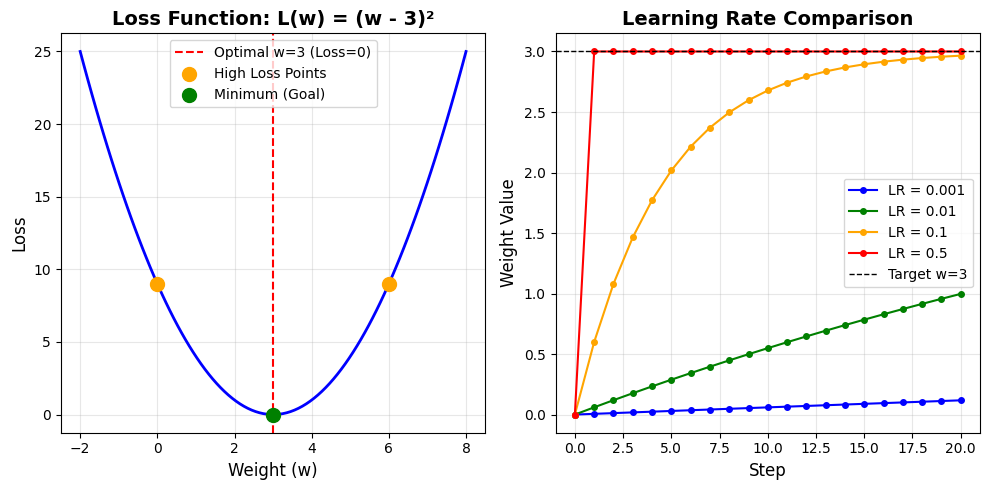

Key Observations:
• Left: The loss is lowest at w=3 (the parabola's bottom)
• Right: Small learning rates converge slowly, large ones may overshoot


In [2]:
# Visualize a simple quadratic loss function: L(w) = (w - 3)^2
w_values = np.linspace(-2, 8, 100)
loss_values = (w_values - 3) ** 2

plt.figure(figsize=(10, 5))

# Plot 1: Loss Function
plt.subplot(1, 2, 1)
plt.plot(w_values, loss_values, 'b-', linewidth=2)
plt.axvline(x=3, color='r', linestyle='--', label='Optimal w=3 (Loss=0)')
plt.scatter([0, 6], [9, 9], color='orange', s=100, zorder=5, label='High Loss Points')
plt.scatter([3], [0], color='green', s=100, zorder=5, label='Minimum (Goal)')
plt.xlabel('Weight (w)', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Function: L(w) = (w - 3)²', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Effect of Learning Rate
plt.subplot(1, 2, 2)
learning_rates = [0.001, 0.01, 0.1, 0.5]
colors = ['blue', 'green', 'orange', 'red']

for lr, color in zip(learning_rates, colors):
    w = 0.0
    trajectory = [w]
    for _ in range(20):
        gradient = 2 * (w - 3)  # derivative of (w-3)^2
        w = w - lr * gradient
        trajectory.append(w)
    plt.plot(trajectory, label=f'LR = {lr}', marker='o', markersize=4, color=color)

plt.axhline(y=3, color='black', linestyle='--', linewidth=1, label='Target w=3')
plt.xlabel('Step', fontsize=12)
plt.ylabel('Weight Value', fontsize=12)
plt.title('Learning Rate Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Observations:")
print("• Left: The loss is lowest at w=3 (the parabola's bottom)")
print("• Right: Small learning rates converge slowly, large ones may overshoot")

### Visualization: What Does a Loss Function Look Like?

Let's visualize a simple loss function: Mean Squared Error (MSE) for a single parameter.

## Part 2: The Intuition (The Blindfolded Hiker)

Now that we know the terms, let's visualize them.

Imagine you are standing on a mountain at night. You are blindfolded. Your goal is to get to the very bottom of the valley.

- **The Mountain**: This is the **Loss Function**. High elevation means High Error. Low elevation means Low Error.
- **Your Location**: This represents the current **Parameters** (Weights) of your model.
- **The Slope**: This is the **Gradient**. It tells you which way is "Up".
- **The Step**: This is the **Learning Rate**. You take a step *opposite* to the slope to go down.

**The Algorithm (Gradient Descent):**
1. Feel the slope with your feet (Calculate Gradient).
2. Turn around to face downhill (Negative Gradient).
3. Take a small step (Learning Rate).
4. Repeat until you are at the bottom (Loss = 0).

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 2D loss landscape (Rosenbrock function - a classic optimization test)
def loss_function(x, y):
    return (1 - x)**2 + 100 * (y - x**2)**2

# Generate grid
x_range = np.linspace(-2, 2, 100)
y_range = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = loss_function(X, Y)

# Gradient descent simulation
def gradient_rosenbrock(x, y):
    dx = -2 * (1 - x) - 400 * x * (y - x**2)
    dy = 200 * (y - x**2)
    return dx, dy

# Run gradient descent from different starting points
start_points = [(-1.5, 2.5), (1.5, 0.5), (-0.5, -0.5)]
paths = []

for start_x, start_y in start_points:
    x, y = start_x, start_y
    path = [(x, y)]
    lr = 0.001
    
    for _ in range(300):
        dx, dy = gradient_rosenbrock(x, y)
        x = x - lr * dx
        y = y - lr * dy
        path.append((x, y))
    
    paths.append(path)

# Create visualization
fig = plt.figure(figsize=(16, 5))

# 3D Surface Plot
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, np.log(Z + 1), cmap='viridis', alpha=0.7)
ax1.set_xlabel('Parameter w1')
ax1.set_ylabel('Parameter w2')
ax1.set_zlabel('Loss (log scale)')
ax1.set_title('3D Loss Landscape\n("The Mountain")', fontweight='bold')
ax1.view_init(elev=30, azim=45)

# Contour Plot with Gradient Descent Paths
ax2 = fig.add_subplot(132)
contour = ax2.contour(X, Y, np.log(Z + 1), levels=20, cmap='viridis', alpha=0.6)
ax2.clabel(contour, inline=True, fontsize=8)

colors_path = ['red', 'blue', 'green']
for path, color, start in zip(paths, colors_path, start_points):
    path_array = np.array(path)
    ax2.plot(path_array[:, 0], path_array[:, 1], color=color, linewidth=2, 
             marker='o', markersize=3, alpha=0.7, label=f'Start: {start}')
    ax2.scatter(start[0], start[1], color=color, s=200, marker='*', 
                edgecolors='black', linewidth=2, zorder=5)

ax2.scatter(1, 1, color='gold', s=300, marker='*', edgecolors='black', 
            linewidth=2, zorder=5, label='Global Minimum')
ax2.set_xlabel('Parameter w1')
ax2.set_ylabel('Parameter w2')
ax2.set_title('Gradient Descent Paths\n(Bird\'s Eye View)', fontweight='bold')
ax2.legend(loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)

# Step-by-step loss reduction
ax3 = fig.add_subplot(133)
for path, color, start in zip(paths, colors_path, start_points):
    losses = [loss_function(x, y) for x, y in path]
    ax3.plot(losses, color=color, linewidth=2, label=f'Start: {start}')

ax3.set_xlabel('Optimization Step')
ax3.set_ylabel('Loss Value')
ax3.set_title('Loss Reduction Over Time', fontweight='bold')
ax3.set_yscale('log')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("• Left: The 3D surface shows the loss landscape - valleys are low loss")
print("• Middle: Different starting points converge to the minimum (gold star)")
print("• Right: Loss decreases exponentially as we 'walk down the mountain'")

### Visualization: The Mountain and Gradient Descent

Let's create a 3D visualization of the "mountain" (loss landscape) and watch gradient descent in action!

## Part 3: The Mechanism (The Recording Tape)

How does PyTorch know the slope of a complex mountain?

Imagine a cassette tape recorder. 

When you create a tensor with `requires_grad=True`, you press **RECORD**.
PyTorch silently watches every operation you do (addition, multiplication, power) and writes it down on a "tape" (the Computation Graph).

When you call `.backward()`, PyTorch **rewinds the tape** and calculates the derivatives step-by-step using the Chain Rule.

In [3]:
# Let's see the "Recording Tape" in action

# 1. Create a tensor and press RECORD
x = torch.tensor(3.0, requires_grad=True)
print(f"x: {x}")

# 2. Do some operations (PyTorch is recording!)
y = x + 2
z = y * y * 3
out = z / 4

print(f"Output: {out}")

# 3. Look at the tape (The 'grad_fn')
# This tells us what operation created this variable
print(f"Function that created 'out': {out.grad_fn}")
print(f"Function that created 'z':   {z.grad_fn}")
print(f"Function that created 'y':   {y.grad_fn}")

x: 3.0
Output: 18.75
Function that created 'out': <DivBackward0 object at 0x13ccb3ca0>
Function that created 'z':   <MulBackward0 object at 0x13ccb3ca0>
Function that created 'y':   <AddBackward0 object at 0x13ccb3ca0>


In [ ]:
# Visualize computation graph for: out = ((x + 2)^2 * 3) / 4
x_val = 3.0
x = torch.tensor(x_val, requires_grad=True)
y = x + 2
z = y * y * 3
out = z / 4

# Calculate gradient
out.backward()

# Create a visual representation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Forward pass with values
ax1.text(0.5, 0.9, f'x = {x_val}', bbox=dict(boxstyle='round', facecolor='lightblue'), 
         ha='center', fontsize=12, fontweight='bold')
ax1.annotate('', xy=(0.5, 0.75), xytext=(0.5, 0.85), 
             arrowprops=dict(arrowstyle='->', lw=2, color='blue'))
ax1.text(0.5, 0.7, f'y = x + 2 = {y.item()}', bbox=dict(boxstyle='round', facecolor='lightgreen'), 
         ha='center', fontsize=12)
ax1.annotate('', xy=(0.5, 0.55), xytext=(0.5, 0.65), 
             arrowprops=dict(arrowstyle='->', lw=2, color='blue'))
ax1.text(0.5, 0.5, f'z = y² × 3 = {z.item()}', bbox=dict(boxstyle='round', facecolor='lightyellow'), 
         ha='center', fontsize=12)
ax1.annotate('', xy=(0.5, 0.35), xytext=(0.5, 0.45), 
             arrowprops=dict(arrowstyle='->', lw=2, color='blue'))
ax1.text(0.5, 0.3, f'out = z / 4 = {out.item()}', bbox=dict(boxstyle='round', facecolor='lightcoral'), 
         ha='center', fontsize=12, fontweight='bold')

ax1.text(0.15, 0.5, 'FORWARD\nPASS', fontsize=14, fontweight='bold', 
         color='blue', rotation=90, va='center')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.axis('off')
ax1.set_title('Forward Pass: Computing Output', fontsize=14, fontweight='bold')

# Right plot: Backward pass with gradients
ax2.text(0.5, 0.3, f'∂out/∂out = 1.0', bbox=dict(boxstyle='round', facecolor='lightcoral'), 
         ha='center', fontsize=12, fontweight='bold')
ax2.annotate('', xy=(0.5, 0.45), xytext=(0.5, 0.35), 
             arrowprops=dict(arrowstyle='->', lw=2, color='red'))
ax2.text(0.5, 0.5, f'∂out/∂z = 0.25', bbox=dict(boxstyle='round', facecolor='lightyellow'), 
         ha='center', fontsize=12)
ax2.annotate('', xy=(0.5, 0.65), xytext=(0.5, 0.55), 
             arrowprops=dict(arrowstyle='->', lw=2, color='red'))
ax2.text(0.5, 0.7, f'∂out/∂y = 7.5', bbox=dict(boxstyle='round', facecolor='lightgreen'), 
         ha='center', fontsize=12)
ax2.annotate('', xy=(0.5, 0.85), xytext=(0.5, 0.75), 
             arrowprops=dict(arrowstyle='->', lw=2, color='red'))
ax2.text(0.5, 0.9, f'∂out/∂x = {x.grad.item()}', bbox=dict(boxstyle='round', facecolor='lightblue'), 
         ha='center', fontsize=12, fontweight='bold')

ax2.text(0.85, 0.5, 'BACKWARD\nPASS', fontsize=14, fontweight='bold', 
         color='red', rotation=90, va='center')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')
ax2.set_title('Backward Pass: Computing Gradients', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Final gradient ∂out/∂x = {x.grad.item()}")
print("This tells us: if x increases by 0.001, out increases by ~0.0075")

### Visualization: The Computation Graph

Let's visualize how PyTorch builds the computation graph and how gradients flow backward.

## Part 4: The Math (Sensitivity)

What does `x.grad = 4.5` actually mean?

It means **Sensitivity**.

If `x.grad` is 4.5, it means:
"If I increase `x` by a tiny amount (0.001), the output `y` will increase by **4.5 times** that amount."

$$ \frac{dy}{dx} \approx \frac{\Delta y}{\Delta x} $$

Let's prove this with code.

In [4]:
# Define a simple function y = x^2
def f(x):
    return x ** 2

x = torch.tensor(4.0, requires_grad=True)
y = f(x)
y.backward()
gradient = x.grad.item()

print(f"At x=4, the gradient is {gradient}")
print("This means if we nudge x by +0.001, y should change by approx 0.008 (8 * 0.001)")

# Let's verify manually
delta = 0.001
x_nudged = 4.0 + delta
y_nudged = x_nudged ** 2

y_original = 4.0 ** 2
actual_change = y_nudged - y_original
predicted_change = gradient * delta

print(f"Actual change in y:    {actual_change:.5f}")
print(f"Predicted change (8*d): {predicted_change:.5f}")
print("See? The gradient predicts how the output responds to input changes!")

At x=4, the gradient is 8.0
This means if we nudge x by +0.001, y should change by approx 0.008 (8 * 0.001)
Actual change in y:    0.00800
Predicted change (8*d): 0.00800
See? The gradient predicts how the output responds to input changes!


In [ ]:
# Visualize gradient as slope for different functions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

functions = [
    (lambda x: x**2, '2x', 'f(x) = x²'),
    (lambda x: x**3, '3x²', 'f(x) = x³'),
    (lambda x: torch.sin(x), 'cos(x)', 'f(x) = sin(x)'),
    (lambda x: torch.exp(x), 'eˣ', 'f(x) = eˣ')
]

x_ranges = [
    np.linspace(-3, 3, 100),
    np.linspace(-2, 2, 100),
    np.linspace(-np.pi, np.pi, 100),
    np.linspace(-2, 2, 100)
]

for idx, (func, grad_formula, title) in enumerate(functions):
    ax = axes[idx // 2, idx % 2]
    x_range = x_ranges[idx]
    
    # Compute function values
    x_tensor = torch.tensor(x_range, requires_grad=True, dtype=torch.float32)
    y_tensor = func(x_tensor)
    
    # Compute gradients
    gradients = []
    for i in range(len(x_range)):
        x_single = torch.tensor(x_range[i], requires_grad=True, dtype=torch.float32)
        y_single = func(x_single)
        y_single.backward()
        gradients.append(x_single.grad.item())
    
    # Plot function
    ax_func = ax
    color = 'tab:blue'
    ax_func.set_xlabel('x', fontsize=11)
    ax_func.set_ylabel('f(x)', color=color, fontsize=11)
    ax_func.plot(x_range, y_tensor.detach().numpy(), color=color, linewidth=2.5, label='Function')
    ax_func.tick_params(axis='y', labelcolor=color)
    ax_func.grid(True, alpha=0.3)
    
    # Plot gradient on secondary y-axis
    ax_grad = ax_func.twinx()
    color = 'tab:red'
    ax_grad.set_ylabel('Gradient (df/dx)', color=color, fontsize=11)
    ax_grad.plot(x_range, gradients, color=color, linewidth=2, linestyle='--', label='Gradient')
    ax_grad.tick_params(axis='y', labelcolor=color)
    
    # Mark a specific point
    test_point = 1.0 if idx != 2 else np.pi/4
    x_test = torch.tensor(test_point, requires_grad=True, dtype=torch.float32)
    y_test = func(x_test)
    y_test.backward()
    grad_test = x_test.grad.item()
    
    ax_func.scatter([test_point], [y_test.item()], color='green', s=100, zorder=5)
    ax_grad.scatter([test_point], [grad_test], color='darkred', s=100, zorder=5)
    
    ax_func.set_title(f'{title}\nGradient: {grad_formula}', fontsize=12, fontweight='bold')
    
    # Add annotation for the test point
    ax_func.annotate(f'x={test_point:.2f}\ngrad={grad_test:.2f}', 
                    xy=(test_point, y_test.item()), 
                    xytext=(test_point + 0.5, y_test.item()),
                    fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.show()

print("Key Insights:")
print("• Blue solid line = Function output")
print("• Red dashed line = Gradient (slope) at each point")
print("• Green dot = Sample point where gradient is calculated")
print("• Where gradient is HIGH, small changes in x cause BIG changes in output")
print("• Where gradient is ZERO, the function is flat (local min/max)")

### Visualization: Understanding Gradient as Sensitivity

Let's visualize how gradients represent the sensitivity of the output to input changes.

## Part 5: The "Gotcha" - Accumulating Gradients

This is the #1 bug for beginners.

PyTorch **accumulates** (adds) gradients by default. It doesn't replace them. This is useful for RNNs, but bad for standard training.

**ALWAYS zero your gradients before the next step.**

In [5]:
weights = torch.ones(2, requires_grad=True)

for i in range(3):
    loss = (weights * 3).sum()
    loss.backward()
    print(f"Step {i}, Gradients: {weights.grad}")
    
    # If we don't zero them, they just keep growing!
    # Uncomment the line below to fix it:
    # weights.grad.zero_()

Step 0, Gradients: tensor([3., 3.])
Step 1, Gradients: tensor([6., 6.])
Step 2, Gradients: tensor([9., 9.])


In [ ]:
# Compare gradient accumulation vs. proper zeroing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Scenario 1: WITHOUT zeroing gradients (BUG!)
weights_no_zero = torch.ones(1, requires_grad=True)
grads_no_zero = []

for i in range(10):
    loss = (weights_no_zero * 2).sum()
    loss.backward()
    grads_no_zero.append(weights_no_zero.grad.item())
    # NOT zeroing gradients - they accumulate!

ax1.plot(range(10), grads_no_zero, marker='o', linewidth=2, markersize=8, color='red')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Gradient Value', fontsize=12)
ax1.set_title('WITHOUT grad.zero_() - INCORRECT!\nGradients Keep Accumulating', 
              fontsize=13, fontweight='bold', color='red')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=2, color='green', linestyle='--', linewidth=2, label='Expected gradient = 2')
ax1.legend()

# Scenario 2: WITH zeroing gradients (CORRECT!)
weights_with_zero = torch.ones(1, requires_grad=True)
grads_with_zero = []

for i in range(10):
    if weights_with_zero.grad is not None:
        weights_with_zero.grad.zero_()  # Zero gradients before backward!
    
    loss = (weights_with_zero * 2).sum()
    loss.backward()
    grads_with_zero.append(weights_with_zero.grad.item())

ax2.plot(range(10), grads_with_zero, marker='o', linewidth=2, markersize=8, color='green')
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Gradient Value', fontsize=12)
ax2.set_title('WITH grad.zero_() - CORRECT!\nGradients Stay Constant', 
              fontsize=13, fontweight='bold', color='green')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=2, color='green', linestyle='--', linewidth=2, label='Expected gradient = 2')
ax2.legend()
ax2.set_ylim(ax1.get_ylim())  # Same scale for comparison

plt.tight_layout()
plt.show()

print("Remember: ALWAYS call .zero_() on gradients before backward() in training loops!")
print(f"Without zeroing: gradients grow from {grads_no_zero[0]} to {grads_no_zero[-1]}")
print(f"With zeroing: gradients stay constant at {grads_with_zero[0]}")

### Visualization: Gradient Accumulation Problem

Let's visualize what happens when we forget to zero gradients.

## Summary Checklist

1. **Loss Function** = The Scorecard (Lower is better).
2. **Learning Rate** = The Step Size (Don't be too greedy).
3. **Gradient** = The Slope (Direction of steepest ascent).
4. **Gradient Descent** = Go opposite the gradient to find the bottom.
5. **requires_grad=True** = Turn on the "Recording Tape".

You are now ready to build Neural Networks.